In [129]:
import pandas as pd
import torch
import torch.nn.functional as F
import sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from transformers import (
    AutoTokenizer, AutoConfig, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    RobertaConfig, 
    RobertaTokenizer, 
    RobertaForSequenceClassification, 
    BertTokenizer,
    RobertaModel,
    RobertaForCausalLM
)
from sklearn.model_selection import train_test_split , StratifiedKFold


from torch.utils.data import DataLoader
from load_data import *
import pickle as pickle
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

In [39]:
model = AutoModelForSequenceClassification.from_pretrained('./model')
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

In [31]:
#print(model.parameters)

In [97]:
def label_to_num(label):
  num_label = []
  with open('dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

def num_to_label(label):
  """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
  """
  origin_label = []
  with open('dict_num_to_label.pkl', 'rb') as f:
    dict_num_to_label = pickle.load(f)
  for v in label:
    origin_label.append(dict_num_to_label[v])
  
  return origin_label

In [40]:
# load dataset
dataset = load_data("./train_entity850.csv")
target = label_to_num(dataset["label"].values)
train_dataset, dev_dataset = train_test_split(
        dataset, test_size=0.15, shuffle=True, stratify=target,
    )

train_label = label_to_num(train_dataset['label'].values)
dev_label = label_to_num(dev_dataset['label'].values)

# tokenizing dataset
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_dev = tokenized_dataset(dev_dataset, tokenizer)

# make dataset for pytorch.
RE_train_dataset = RE_Dataset(tokenized_train, train_label)
RE_dev_dataset = RE_Dataset(tokenized_dev, dev_label)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#print(model.config)
model.to(device)
print()

cuda:0



In [49]:
def get_confusion_matrix(logit_or_preds, labels, is_logit=True):
    """ Compute and Draw the Confusion Matrix """
    preds = np.argmax(logit_or_preds, axis=1).ravel() if is_logit else logit_or_preds
    cm = confusion_matrix(labels, preds)
    norm_cm = cm / np.sum(cm, axis=1)[:,None]
    cm = pd.DataFrame(norm_cm, index=RELATION_CLASS, columns=RELATION_CLASS)
    fig = plt.figure(figsize=(12,9))
    sns.heatmap(cm, annot=True)
    return fig

In [103]:
def klue_re_micro_f1(preds, labels):
    """KLUE-RE micro f1 (except no_relation)"""
    label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
    no_relation_label_idx = label_list.index("no_relation")
    label_indices = list(range(len(label_list)))
    label_indices.remove(no_relation_label_idx)
    return sklearn.metrics.f1_score(labels, preds, average="micro", labels=label_indices) * 100.0

def klue_re_auprc(probs, labels):
    """KLUE-RE AUPRC (with no_relation)"""
    labels = np.eye(30)[labels]

    score = np.zeros((30,))
    for c in range(30):
        targets_c = labels.take([c], axis=1).ravel()
        preds_c = probs.take([c], axis=1).ravel()
        precision, recall, _ = sklearn.metrics.precision_recall_curve(targets_c, preds_c)
        score[c] = sklearn.metrics.auc(recall, precision)
    return np.average(score) * 100.0

def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions
    
  #cm_fig = get_confusion_matrix(preds, labels)

  # calculate accuracy using sklearn's function
  f1 = klue_re_micro_f1(preds, labels)
  auprc = klue_re_auprc(probs, labels)
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.
    
  #wandb.log({"f1":f1, "auprc":auprc, "acc":acc})

  return {
      'micro f1 score': f1,
      'auprc' : auprc,
      'accuracy': acc,
  }

In [285]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("cuda empty cache!!")

cuda empty cache!!


In [286]:
    # 사용한 option 외에도 다양한 option들이 있습니다.
training_args = TrainingArguments(
        output_dir='./temp',          # output directory
        save_total_limit=5,              # number of total save model.
        save_steps=500,                 # model saving step.
        num_train_epochs=1,              # total number of training epochs
        learning_rate=1e-4,               # learning_rate
        per_device_train_batch_size=16,  # batch size per device during training
        per_device_eval_batch_size=16,   # batch size for evaluation
        warmup_ratio=0.1,
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logss',            # directory for storing logs
        logging_steps=100,              # log saving step.
        evaluation_strategy='steps', # evaluation strategy to adopt during training
                                    # `no`: No evaluation during training.
                                    # `steps`: Evaluate every `eval_steps`.
                                    # `epoch`: Evaluate every end of epoch.
        eval_steps = 500,            # evaluation step.
        metric_for_best_model = 'eval_micro f1 score', #eval_micro f1 score
        load_best_model_at_end = True ,
        lr_scheduler_type = 'cosine', #default: linear
    )

    
trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=RE_train_dataset,         # training dataset
        eval_dataset=RE_dev_dataset,             # evaluation dataset
        compute_metrics=compute_metrics         # define metrics function
    )

y_preds = trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Both warmup_ratio and warmup_steps given, warmup_steps will override any effect of warmup_ratio during training
***** Running training *****
  Num examples = 33979
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2124
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Micro f1 score,Auprc,Accuracy
500,1.016700,0.851598,78.521693,78.514281,0.764716
1000,0.996000,0.843230,77.801224,76.317067,0.744706
1500,0.689500,0.613852,83.689466,84.470357,0.809405
2000,0.442100,0.404105,88.632442,90.157426,0.862431


***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-500
Configuration saved in ./temp/checkpoint-500/config.json
Model weights saved in ./temp/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1000
Configuration saved in ./temp/checkpoint-1000/config.json
Model weights saved in ./temp/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1500
Configuration saved in ./temp/checkpoint-1500/config.json
Model weights saved in ./temp/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-2000
Configuration saved in ./temp/checkpoint-2000/config.json
Model weights saved in ./temp/checkpoint-2000/pytorch_model.bin


Training completed. Do not fo

In [ ]:
y_preds = trainer.predict(RE_train_dataset)


In [287]:
labels = train_label

In [288]:
def inference(model, tokenized_sent, device):
  """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
  """
  dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
  model.eval()
  output_pred = []
  output_prob = []
  for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
      #print(data)
      outputs = model(
          input_ids=data['input_ids'].to(device),
          attention_mask=data['attention_mask'].to(device),
          token_type_ids=data['token_type_ids'].to(device)
          )

    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
  return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

In [289]:
#pred_answer, output_prob = inference(model, RE_train_dataset, device) # model에서 class 추론
pred_answer, output_prob = inference(model, RE_dev_dataset, device)
pred_answer = num_to_label(pred_answer) # 숫자로 된 class를 원래 문자열 라벨로 변환.

100%|██████████| 375/375 [01:22<00:00,  4.57it/s]


In [290]:
#labels = num_to_label(train_label)
labels = num_to_label(dev_label)

In [291]:
#print(RE_train_dataset)
#print(RE_train_dataset[0]['labels'])
#print(num_to_label(RE_train_dataset[0]['labels']))
#print(train_label)
print(y_preds)
print("=========")
print(len(labels))
print(len(pred_answer))
print("---------")
count = 0
for a, b in zip(labels, pred_answer):
    if a != b:
        count += 1
print(count)

TrainOutput(global_step=2124, training_loss=0.7214067072069129, metrics={'train_runtime': 2068.0863, 'train_samples_per_second': 16.43, 'train_steps_per_second': 1.027, 'total_flos': 1.4906740382326716e+16, 'train_loss': 0.7214067072069129, 'epoch': 1.0})
5997
5997
---------
825


In [292]:
#print(num_to_label(train_label))

In [293]:
label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
len(label_list)

30

In [294]:
print(np.arange(0.6, 30, 1))
print(len(np.arange(0.5, 30, 1)))
#print(cm_fig)

[ 0.6  1.6  2.6  3.6  4.6  5.6  6.6  7.6  8.6  9.6 10.6 11.6 12.6 13.6
 14.6 15.6 16.6 17.6 18.6 19.6 20.6 21.6 22.6 23.6 24.6 25.6 26.6 27.6
 28.6 29.6]
30


In [295]:
###cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
###sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

In [296]:
print(cm.sum(axis=0))
print(cm.sum(axis=1))
#print(cm_norm)

[1429  198  122   68   46  280   63  117  179  121   86  643  150   91
   80  170   73  536  185   57   78  127  107   55  127  124  124  127
  119  315]
[1421  199  122   66   48  288   59  117  187  120   86  646  152   94
   71  172   72  531  192   60   79  128  107   45  129  123  124  127
  123  309]


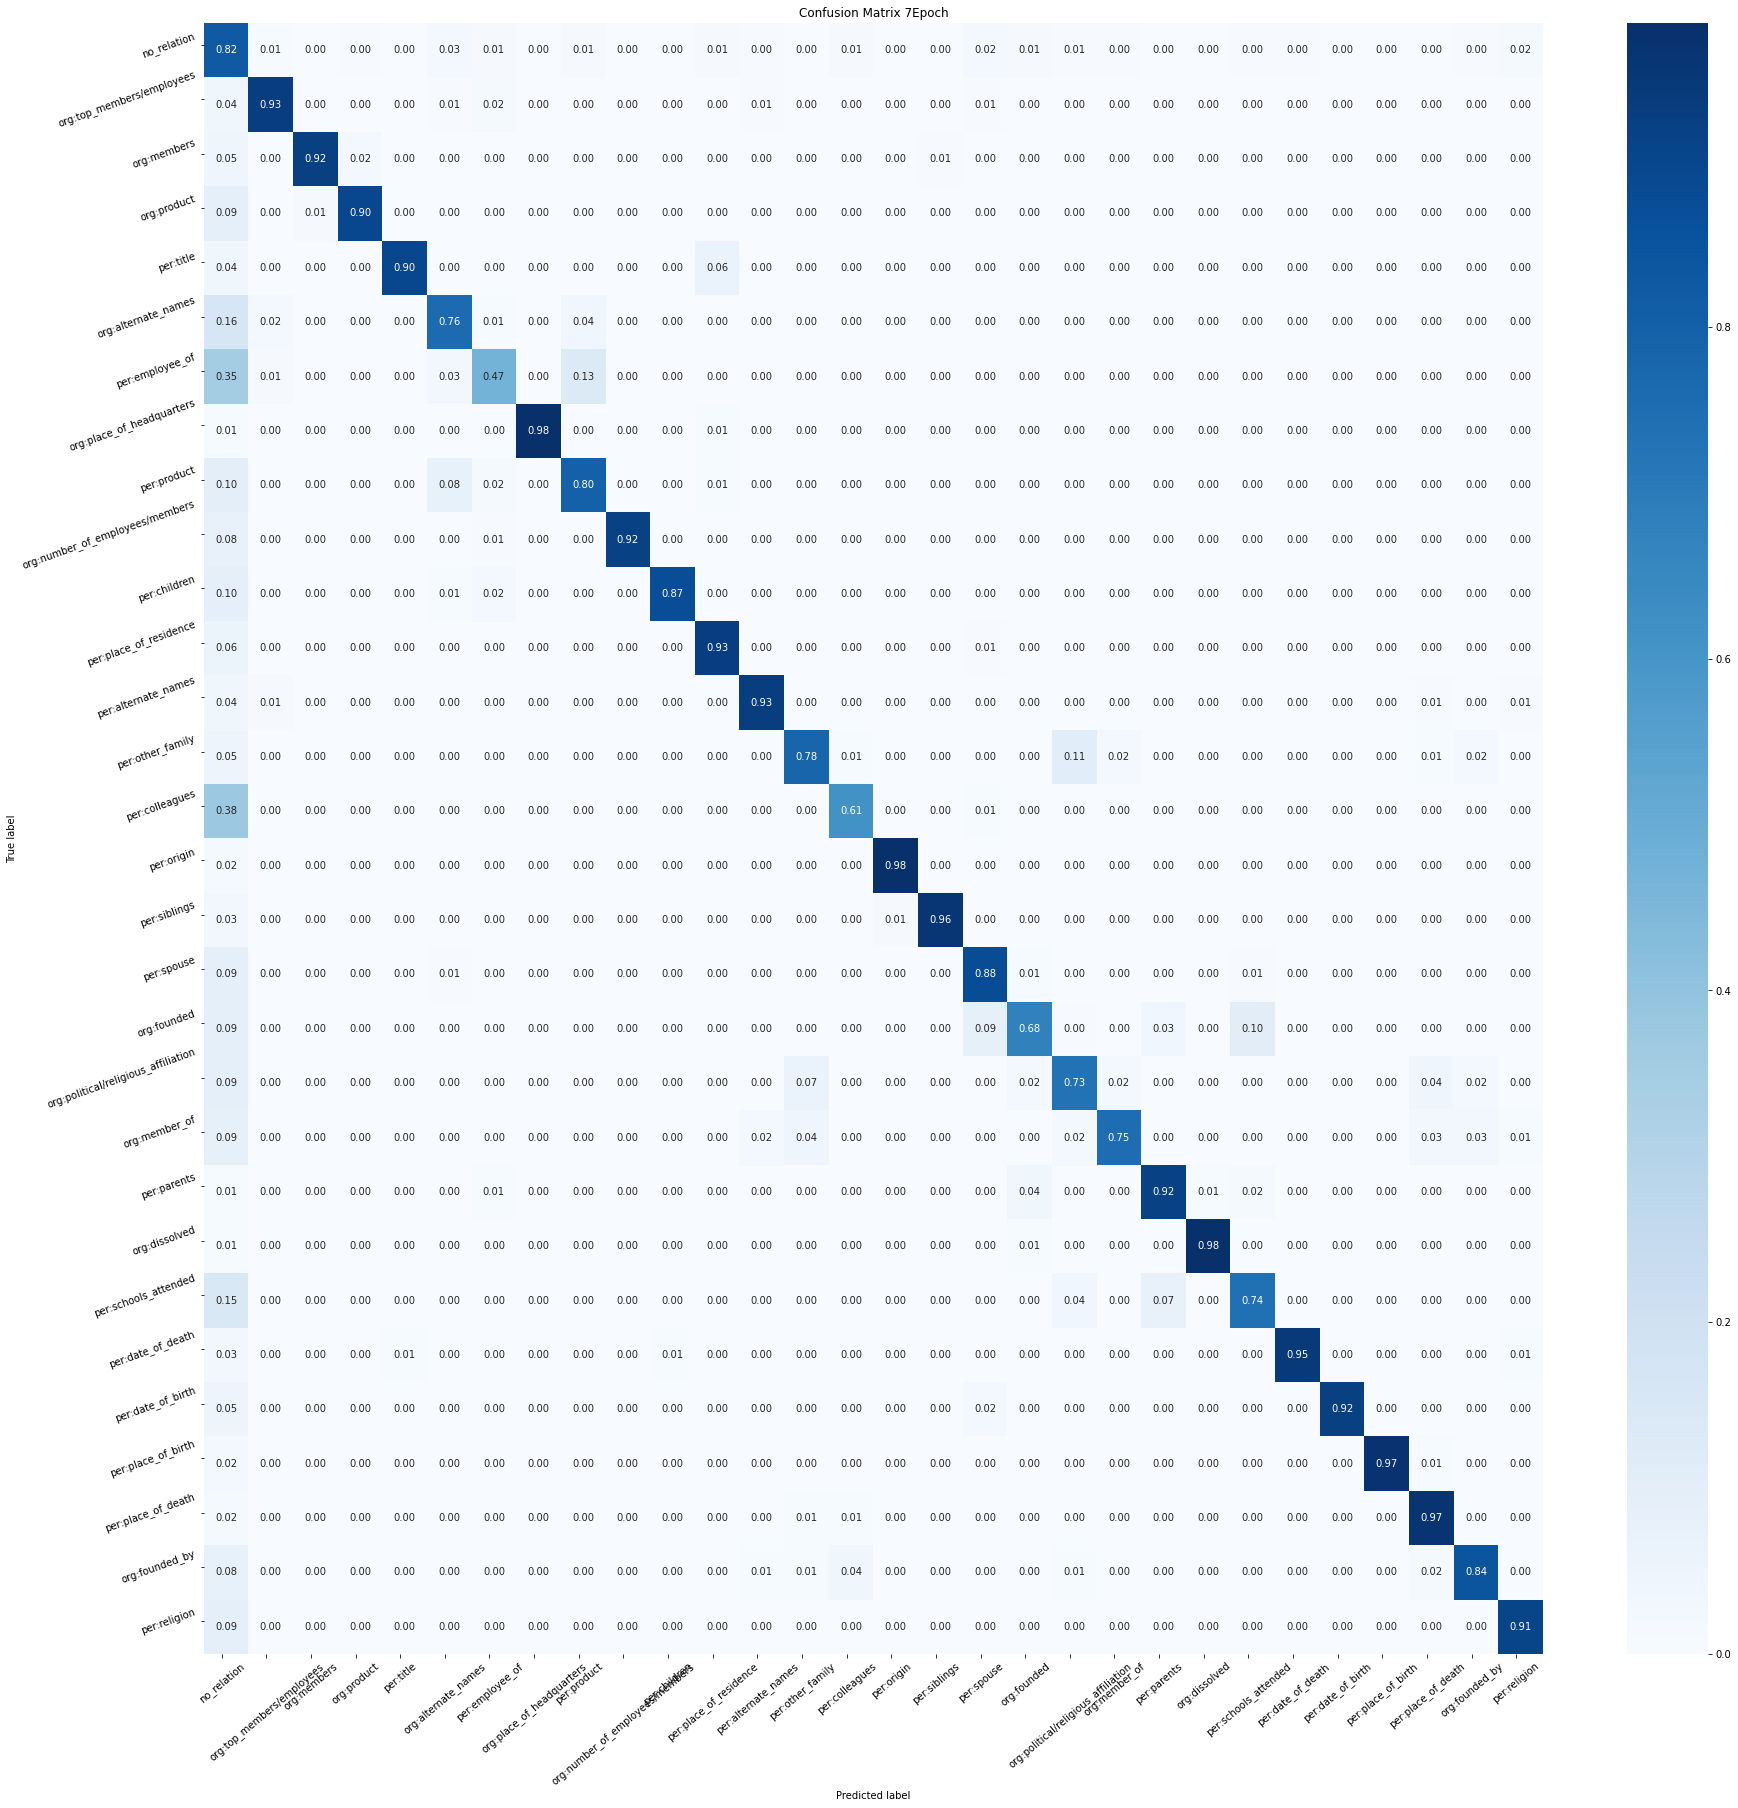

In [297]:
#print(pred_answer)



fig = plt.figure(figsize=(30,30))

cm = confusion_matrix(pred_answer, labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
#ax.set(title='Confusion Matrix', ylabel='True label', xlabel='Predicted label', xticks=label_list, yticks=label_list)


ticks = np.arange(0.4, 30, 1)

plt.title('Confusion Matrix 7Epoch')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks, label_list, rotation=40)
plt.yticks(ticks, label_list, rotation=20)



plt.show()